## Description:
Run many models looking at:
1 - BMI and omic variables longitudinally 
2 - BMI and variable changes from BL-6m and 6m-12m

In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib as mpl
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats
from joblib import dump
sns.set_context("poster")
mpl.rcParams['figure.figsize'] = (11,8)

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from em_utils import *

# test and train set directories for input data
longitudinal_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined/"
delta_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/zachs_rerun/drift_fs/csv/all_omic_processed_data/deltas/"
clin_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2/merf_ready"
# Where hyperparameter training results are
delta_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/6.two_timepoints_deltas"
long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/5.combined"
func_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/3.functional"
taxa_long_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/2.taxa"
clinical_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical"
micom_df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/4.micom"

In [2]:
# test and train longitudinal files 
test_all = pd.read_csv(os.path.join(longitudinal_dir, 'test_merged_all_omics_raw_meta.csv'))  
train_all = pd.read_csv(os.path.join(longitudinal_dir, 'training_merged_all_omics_raw_meta.csv'))  
print("test long shape = ", test_all.shape)
print("train long shape = ", train_all.shape)
print("test longitudinal: ", test_all.columns)
print("train longitudinal: ", train_all.columns)

# test and train delta files 
test_delta = read_data(delta_dir, "jan30_all_delta_test_imp_varcheck.csv")
train_delta = read_data(delta_dir, "jan30_all_delta_train_imp_varcheck.csv")
print("test delta shape = ", test_delta.shape)
print("train delta shape = ", train_delta.shape)
print("test delta: ", test_delta.columns)
print("train delta: ", train_delta.columns)

# hyperparameter training files 
delta_df = pd.read_csv(os.path.join(delta_df_dir, 'jan30_2times_all_omic_deltas_BMI_remove_time_var_imputed_swapped.csv'))
long_df = pd.read_csv(os.path.join(long_df_dir, 'jan13_params_fine_tuning_results_all_omics.csv'))
func_df = pd.read_csv(os.path.join(func_df_dir, 'dec6_magggie_params_fine_tuning_results_raw_functional.csv'))
taxa_df = pd.read_csv(os.path.join(taxa_long_df_dir, 'dec6_maggie_params_tuning_raw_taxa_oob.csv'))
micom_df = pd.read_csv(os.path.join(micom_df_dir, 'dec6_maggie_params_fine_tuning_results_raw_micom.csv'))
meta_df = pd.read_csv(os.path.join(clinical_df_dir, 'dec5_maggie_params_tuning_raw_clinical_oob.csv'))
#meta_df = pd.read_csv('/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/1.clinical/fine_tuning_results_raw_clinical.csv')

test long shape =  (66, 635)
train long shape =  (268, 635)
test longitudinal:  Index(['Unnamed: 0_test_long', 'record_id', 'subject_id', 'randomized_group',
       'cohort_number', 'sex', 'race', 'age', 'time', 'Glucose',
       ...
       'outcome_BMI_fnl_merged_data', 'Unnamed: 0_merged_data', 'bmi_prs',
       'old_or_new', 'predicted_BL_BMI', 'differences_BL_BMI',
       'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs',
       'methyl_bmi_rs_standardized'],
      dtype='object', length=635)
train longitudinal:  Index(['Unnamed: 0_train_long', 'record_id', 'subject_id', 'randomized_group',
       'cohort_number', 'sex', 'race', 'age', 'time', 'Glucose',
       ...
       'outcome_BMI_fnl_merged_data', 'Unnamed: 0_merged_data', 'bmi_prs',
       'old_or_new', 'predicted_BL_BMI', 'differences_BL_BMI',
       'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs',
       'methyl_bmi_rs_standardized'],
      dtype='object', length=635)
test delta shape =  (62, 920)
train delta shape 

### Longitudinal BMI first 

In [3]:
# Drop some columns 
train_long = train_all.drop(['Unnamed: 0_y','Unnamed: 0_x', 'Unnamed: 0_train_long', 'Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_x', 'all_samples_y', 'record_id','SampleID',
                    'time_x', 'time_y', 'x_t', 't', 'time', 'outcome_BMI_fnl_x', 'outcome_BMI_fnl_y', 
                    'outcome_BMI_fnl_merged_data', 'old_or_new', 'predicted_BL_BMI', 
                    'differences_BL_BMI', 'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs', 'methyl_bmi_rs_standardized'], 
                    axis=1)

test_long = test_all.drop(['Unnamed: 0_y','Unnamed: 0_x', 'Unnamed: 0_test_long', 'Unnamed: 0_merged_data',
                    'sample_id','subject_id', 'all_samples_x', 'all_samples_y', 'record_id', 'SampleID',
                    'time_x', 'time_y', 'x_t', 't', 'time', 'outcome_BMI_fnl_x', 'outcome_BMI_fnl_y', 
                    'outcome_BMI_fnl_merged_data', 'old_or_new', 'predicted_BL_BMI', 
                    'differences_BL_BMI', 'diff_BMI_quartile', 'diff_BMI_std', 'methyl_bmi_rs', 'methyl_bmi_rs_standardized'], 
                    axis=1)
print("test long shape = ", test_long.shape)
print("train long shape = ", train_long.shape)

test_long.rename(columns={'outcome_BMI_fnl_test_long': 'outcome_bmi_fnl'}, inplace=True)
train_long.rename(columns={'outcome_BMI_fnl_train_long': 'outcome_bmi_fnl'}, inplace=True)

print("test longitudinal: ", list(test_long.columns))
print("train longitudinal: ", list(train_long.columns))

test long shape =  (66, 610)
train long shape =  (268, 610)
test longitudinal:  ['randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'outcome_bmi_fnl', 'proton', 'Diacetyl', 'Butyrate', 'Formate', 'acetone', 'X2.methylbutyrate', 'Valeric.Acid', 'Methane', 'X1.4.Dihydroxy.2.naphthoate', 'X2.Oxoglutarate', 'Pyruvate', 'D.lactate', 'L.lactate', 'laurate', 'Phenol', 'L.Carnitine', 'Isopropanol', 'p.Cresol', 'O2', 'X1.Propanol', 'butanol', 'Propanal', 'X4.hydroxyphenylacetate', 'X.S..propane.1.2.diol', 'Propane.1.3.diol', 'R_R__2_3_Butanediol', 'Oxaloacetate', 'sulfate', 'octadecenoate..n.C18.1.', 'o.Succinylbenzoate', 'Thymidine', 'Reduced.riboflavin', 'Riboflavin', 'X2.Hydroxyphenylacetate', 'Sulfite', 'thiosulfate.2..', 'X.3.4.dihydroxyphenyl.acetate', 'Diphosphate', 'trimethylamine', 'glycine.betaine', 'Choline', 'Trimethylamine.N.oxide', 'Isochorismate', 'Inosine', 'xanthosine

In [4]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_long.columns.get_loc("proton")
carbon_dioxide_column = train_long.columns.get_loc("Carbon.dioxide")
proton_column_test = test_long.columns.get_loc("proton")
carbon_dioxide_column_test = test_long.columns.get_loc("Carbon.dioxide")

# Columns to KEEP for only meta 
meta_keep = ['all_samples','outcome_bmi_fnl', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']
# Columns to KEEP for only meta + GRS
meta_grs = ['all_samples','outcome_bmi_fnl', 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'bmi_prs']
# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_grs + [col for col in train_long.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_grs + [col for col in test_long.columns if col.startswith("g__")]
# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_long.columns if col not in train_long.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa + [col for col in test_long.columns if col not in test_long.columns[proton_column_test:carbon_dioxide_column_test+1]]
# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']

## 1.1 Trying Meta from omic DF

PTEV is the best one 
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 777.5917090904233 at iteration 1.
INFO     [merf.py:307] Training GLL is 754.1236610914101 at iteration 2.
INFO     [merf.py:307] Training GLL is 773.825823792849 at iteration 1.
INFO     [merf.py:307] Training GLL is 753.5910009929249 at iteration 2.
INFO     [merf.py:307] Training GLL is 620.9196300527598 at iteration 1.
INFO     [merf.py:307] Training GLL is 634.8231009595936 at iteration 2.
INFO     [merf.py:307] Training GLL is 612.7646226153596 at iteration 1.
INFO     [merf.py:307] Training GLL is 628.6264462413709 at iteration 2.
INFO     [merf.py:307] Training GLL is 609.2395804123154 at iteration 3.
INFO     [merf.py:307] Training GLL is 592.2246326697812 at iteration 4.
INFO     [merf.py:307] Training GLL is 578.7890009254286 at iteration 5.
INFO     [merf.py:307] Training GLL is 568.836198457408 at iteration 6.
INFO     [merf.py:307] Training GLL is 563.7587806190248 at iteration 7.
INFO     [merf.py:307] Training GLL is 558.7825041444

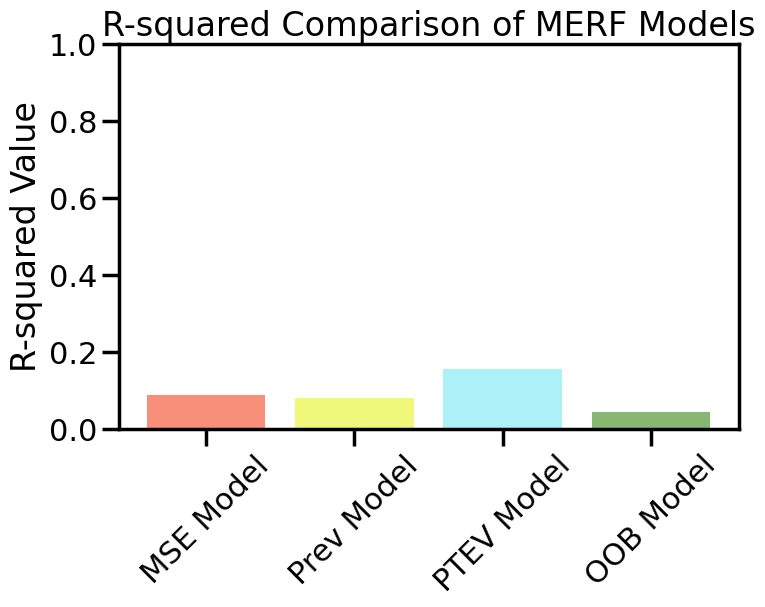

Best model: PTEV Model with R-squared: 0.1568
Top 15 feature importances for the best model:
                   Feature  Importance
7                  HOMA_IR    0.424210
8             Insulin_endo    0.179520
10      Triglyceride_lipid    0.111312
5                  Glucose    0.073516
1            cohort_number    0.064936
6   HDL_Total_Direct_lipid    0.058024
4                      age    0.040994
9           LDL_Calculated    0.033517
3                     race    0.006281
0         randomized_group    0.003929
2                      sex    0.003760
---------- Run best MERF 🧮 ----------


In [5]:
train_l = train_long[meta_keep]
test_l = test_long[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_only_meta_merf_bmi_long_feb6_all.png'
feature_imp_out = 'fi_only_meta_merf_bmi_long_feb6_all.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_run1, fi_run1 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")# Define the parameter grid list
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# only_meta = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="only_meta_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in only_meta:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection


## 1.2 trying Meta + Genetic info from omic DF
PTEV model
First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 759.982882276405 at iteration 1.
INFO     [merf.py:307] Training GLL is 746.0861438213354 at iteration 2.
INFO     [merf.py:307] Training GLL is 762.1681714538116 at iteration 1.
INFO     [merf.py:307] Training GLL is 747.5714301562057 at iteration 2.
INFO     [merf.py:307] Training GLL is 583.242209222639 at iteration 1.
INFO     [merf.py:307] Training GLL is 624.1399762008983 at iteration 2.
INFO     [merf.py:307] Training GLL is 581.7331669937166 at iteration 1.
INFO     [merf.py:307] Training GLL is 620.376158142226 at iteration 2.
INFO     [merf.py:307] Training GLL is 604.2854651315977 at iteration 3.
INFO     [merf.py:307] Training GLL is 590.9379718343409 at iteration 4.
INFO     [merf.py:307] Training GLL is 578.8601904398087 at iteration 5.
INFO     [merf.py:307] Training GLL is 568.4249868089017 at iteration 6.
INFO     [merf.py:307] Training GLL is 562.6516709884042 at iteration 7.
INFO     [merf.py:307] Training GLL is 561.73264054237

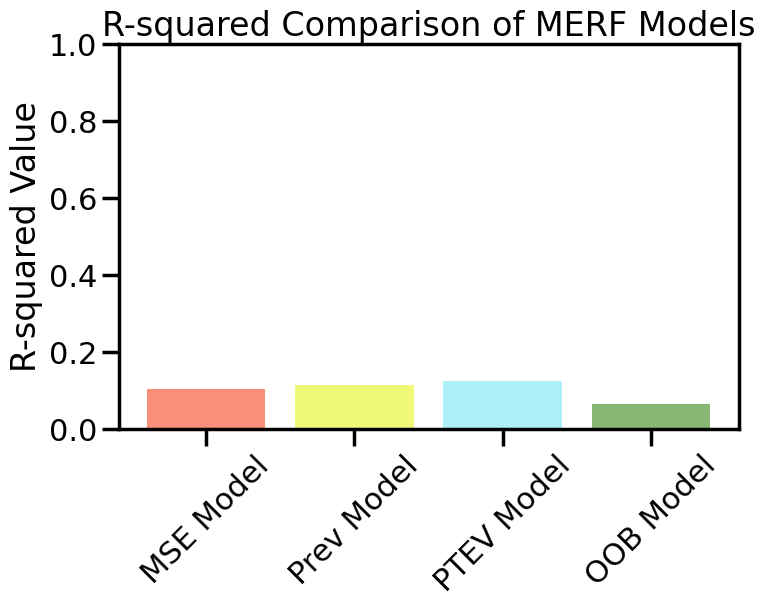

Best model: PTEV Model with R-squared: 0.1257
Top 15 feature importances for the best model:
                   Feature  Importance
7                  HOMA_IR    0.388718
8             Insulin_endo    0.172322
11                 bmi_prs    0.124658
10      Triglyceride_lipid    0.093725
5                  Glucose    0.057330
1            cohort_number    0.056522
6   HDL_Total_Direct_lipid    0.036960
9           LDL_Calculated    0.031045
4                      age    0.028909
3                     race    0.004937
2                      sex    0.002776
0         randomized_group    0.002096
---------- Run best MERF 🧮 ----------


In [6]:
train_l = train_long[meta_grs]
test_l = test_long[meta_grs]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_grs_merf_bmi_long_feb6_all.png'
feature_imp_out = 'fi_meta_grs_merf_bmi_long_feb6_all.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_run2, fi_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")# Define the parameter grid list
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# only_meta_grs = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="only_meta_grs_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in only_meta_grs:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")

## 1.3 trying Meta + Genetic + Taxa info from omic DF

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 635.0570133024542 at iteration 1.
INFO     [merf.py:307] Training GLL is 659.3975587810662 at iteration 2.
INFO     [merf.py:307] Training GLL is 641.1481648396214 at iteration 1.
INFO     [merf.py:307] Training GLL is 655.6761092432226 at iteration 2.
INFO     [merf.py:307] Training GLL is 430.3303405813684 at iteration 1.
INFO     [merf.py:307] Training GLL is 493.50908125267546 at iteration 2.
INFO     [merf.py:307] Training GLL is 420.91439840363967 at iteration 1.
INFO     [merf.py:307] Training GLL is 474.4815192795437 at iteration 2.
INFO     [merf.py:307] Training GLL is 462.50080404442207 at iteration 3.
INFO     [merf.py:307] Training GLL is 449.18877908297713 at iteration 4.
INFO     [merf.py:307] Training GLL is 436.63034912862423 at iteration 5.
INFO     [merf.py:307] Training GLL is 425.401501085325 at iteration 6.
INFO     [merf.py:307] Training GLL is 417.6985463459307 at iteration 7.
INFO     [merf.py:307] Training GLL is 415.4293

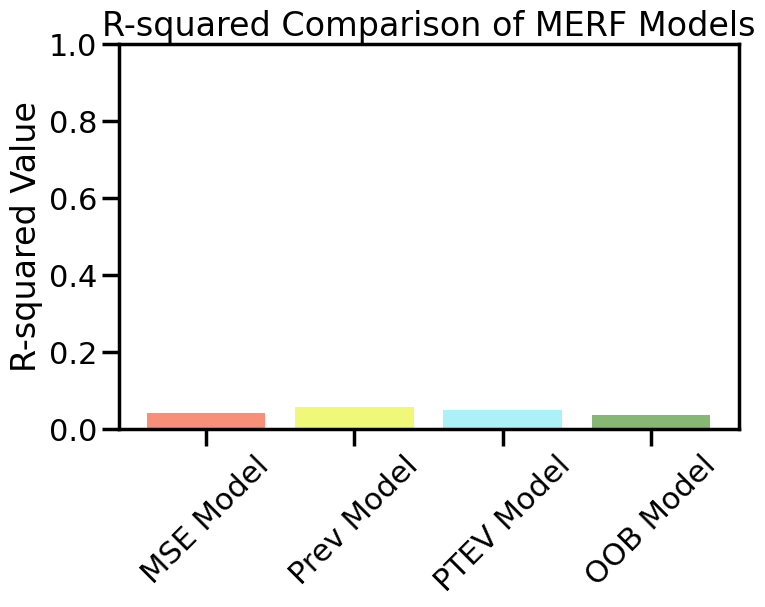

Best model: Prev Model with R-squared: 0.0571
Top 15 feature importances for the best model:
                 Feature  Importance
7                HOMA_IR    0.555429
8           Insulin_endo    0.089499
189           g__Dorea_A    0.023352
108           g__UBA1417    0.018703
11               bmi_prs    0.016956
5                Glucose    0.015444
129    g__Ruminococcus_D    0.014623
182     g__Enterocloster    0.014443
1          cohort_number    0.014260
144                g___1    0.013252
10    Triglyceride_lipid    0.011138
133           g__CAG.274    0.010176
117  g__Ruthenibacterium    0.008258
43        g__Collinsella    0.006150
62      g__Streptococcus    0.005668
---------- Run best MERF 🧮 ----------


In [7]:
train_l = train_long[meta_grs_taxa]
test_l = test_long[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_grs_taxa_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_meta_grs_taxa_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)

r2_run3, fi_run3 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# meta_grs_tax = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="meta_grs_tax_results")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in meta_grs_tax:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection

## 1.4 trying Meta + Genetic + Taxa + Functional info from omic DF

lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 640.470041969913 at iteration 1.
INFO     [merf.py:307] Training GLL is 659.2053757894486 at iteration 2.
INFO     [merf.py:307] Training GLL is 636.5106094507296 at iteration 1.
INFO     [merf.py:307] Training GLL is 656.5082527079729 at iteration 2.
INFO     [merf.py:307] Training GLL is 419.51429169852844 at iteration 1.
INFO     [merf.py:307] Training GLL is 470.80434683799746 at iteration 2.
INFO     [merf.py:307] Training GLL is 409.64106759180055 at iteration 1.
INFO     [merf.py:307] Training GLL is 459.01731677820624 at iteration 2.
INFO     [merf.py:307] Training GLL is 448.9156625892275 at iteration 3.
INFO     [merf.py:307] Training GLL is 441.54177313739444 at iteration 4.
INFO     [merf.py:307] Training GLL is 430.33758116507335 at iteration 5.
INFO     [merf.py:307] Training GLL is 419.37281476851405 at iteration 6.
INFO     [merf.py:307] Training GLL is 411.8927576454967 at iteration 7.
INFO     [merf.py:307] Training GLL is 412.23

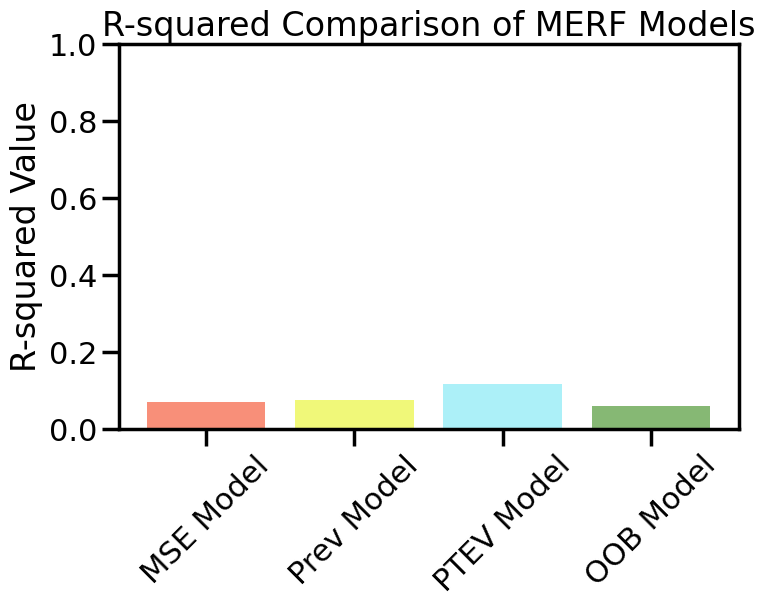

Best model: PTEV Model with R-squared: 0.1176
Top 15 feature importances for the best model:
                                               Feature  Importance
7                                              HOMA_IR    0.380152
8                                         Insulin_endo    0.075722
108                                         g__UBA1417    0.019301
189                                         g__Dorea_A    0.018352
10                                  Triglyceride_lipid    0.014593
11                                             bmi_prs    0.013545
447                  TCA.cycle.VII..acetate.producers.    0.013322
291          superpathway.of.polyamine.biosynthesis.II    0.012286
459     aromatic.biogenic.amine.degradation..bacteria.    0.011988
5                                              Glucose    0.010027
133                                         g__CAG.274    0.009124
43                                      g__Collinsella    0.008769
1                                   

In [8]:
train_l = train_long[meta_grs_taxa_functional]
test_l = test_long[meta_grs_taxa_functional_test]
# Check for duplicate column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
# Remove duplicate columns
test_l = test_l.loc[:, ~test_l.columns.duplicated()]
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_grs_taxa_functional_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_meta_grs_taxa_functional_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)
# Run the analysis multiple times
r2_run4, fi_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
param_grid_list = [
    {'n_estimators': 500, 'max_depth': None, 
     'min_samples_split': 0.05, 'max_iter': 2}
]
# Call the run_merf function with the required parameters
#meta_grs_tax_func = run_merf(X, Y, Z, clusters_train,
#                     X_new, Y_new, Z_new, clusters_new, 
#                     param_grid_list, results_name="meta_grs_tax_func_results")
# View the "only_meta" output
#print("Viewing the 'only_meta' output:")
#for result in meta_grs_tax_func:
#    print(f"Model Parameters: {result['params']}")
#    print(f"R-squared: {result['r2']:.4f}")
#    print("Feature Importances:")
#    for feature, importance in zip(X.columns, result['feature_importances']):
#        print(f"{feature}: {importance:.4f}")
#    print("\n")

## 1.5 all but meta omic df 

First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 709.564565036623 at iteration 1.
INFO     [merf.py:307] Training GLL is 738.0015645372903 at iteration 2.
INFO     [merf.py:307] Training GLL is 706.5221325849913 at iteration 1.
INFO     [merf.py:307] Training GLL is 736.5388581609952 at iteration 2.
INFO     [merf.py:307] Training GLL is 470.75776928582945 at iteration 1.
INFO     [merf.py:307] Training GLL is 522.7782305922157 at iteration 2.
INFO     [merf.py:307] Training GLL is 449.8299926519588 at iteration 1.
INFO     [merf.py:307] Training GLL is 516.520205316719 at iteration 2.
INFO     [merf.py:307] Training GLL is 518.4704271273713 at iteration 3.
INFO     [merf.py:307] Training GLL is 509.59583768764014 at iteration 4.
INFO     [merf.py:307] Training GLL is 502.1625102371306 at iteration 5.
INFO     [merf.py:307] Training GLL is 500.99139801135664 at iteration 6.
INFO     [merf.py:307] Training GLL is 506.30100963740233 at iteration 7.
INFO     [merf.py:307] Training GLL is 504.473374

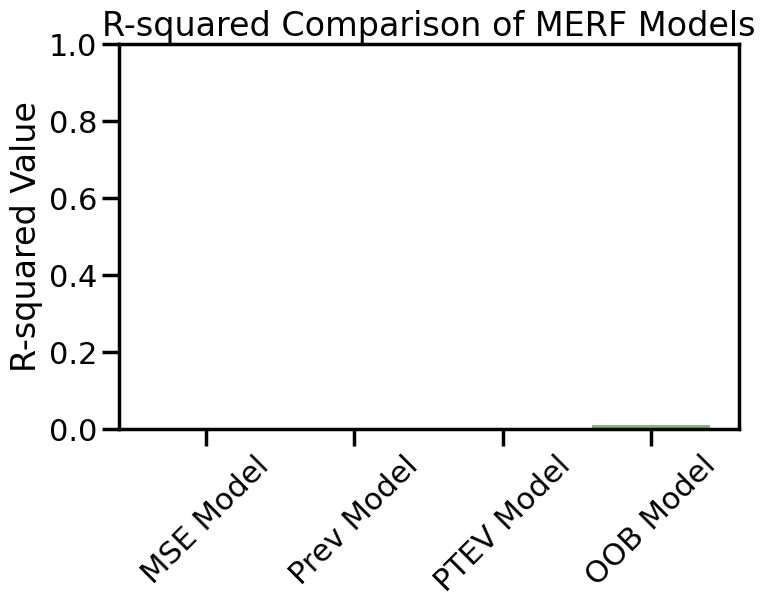

Best model: OOB Model with R-squared: 0.0102
Top 15 feature importances for the best model:
                                               Feature  Importance
423                              g__Alistipes_A_871400    0.072188
347                  TCA.cycle.VII..acetate.producers.    0.041473
192           superpathway.of.polyamine.biosynthesis.I    0.034549
561                                g__Blautia_A_141781    0.028712
420                              g__Odoribacter_865974    0.026579
362  X6.hydroxymethyl.dihydropterin.diphosphate.bio...    0.017000
195  superpathway.of.histidine..purine..and.pyrimid...    0.016774
230                           GDP.mannose.biosynthesis    0.015459
269  X6.hydroxymethyl.dihydropterin.diphosphate.bio...    0.012636
587                                   g__Enterocloster    0.012592
215  L.arginine.biosynthesis.III..via.N.acetyl.L.ci...    0.009780
476                                     g__Copromorpha    0.009251
474                                  

In [9]:
train_l = train_long.drop(all_but_meta, axis = 1)
test_l = test_long.drop(all_but_meta, axis = 1)
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_but_meta_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_all_but_meta_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)
r2_run5, fi_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
# param_grid_list = [
#     {'n_estimators': 500, 'max_depth': None, 
#      'min_samples_split': 0.05, 'max_iter': 2}
# ]
# # Call the run_merf function with the required parameters
# grs_tax_func_micom = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="grs_tax_func_micom")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in grs_tax_func_micom:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")
# # End of Selection

## 1.6 All omics 

First 5 columns for the lowest mean_ptev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 20, dtype: float64

First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 639.389378684091 at iteration 1.
INFO     [merf.py:307] Training GLL is 655.3292954679438 at iteration 2.
INFO     [merf.py:307] Training GLL is 640.8709201037748 at iteration 1.
INFO     [merf.py:307] Training GLL is 658.0341743078266 at iteration 2.
INFO     [merf.py:307] Training GLL is 409.9391865178923 at iteration 1.
INFO     [merf.py:307] Training GLL is 467.6325458734661 at iteration 2.
INFO     [merf.py:307] Training GLL is 399.772292295814 at iteration 1.
INFO     [merf.py:307] Training GLL is 454.70640788652366 at iteration 2.
INFO     [merf.py:307] Training GLL is 440.8673196915596 at iteration 3.
INFO     [merf.py:307] Training GLL is 431.07030302373926 at iteration 4.
INFO     [merf.py:307] Training GLL is 424.9525370738887 at iteration 5.
INFO     [merf.py:307] Training GLL is 415.76553784853536 at iteration 6.
INFO     [merf.py:307] Training GLL is 412.83271163156695 at iteration 7.
INFO     [merf.py:307] Training GLL is 411.104664

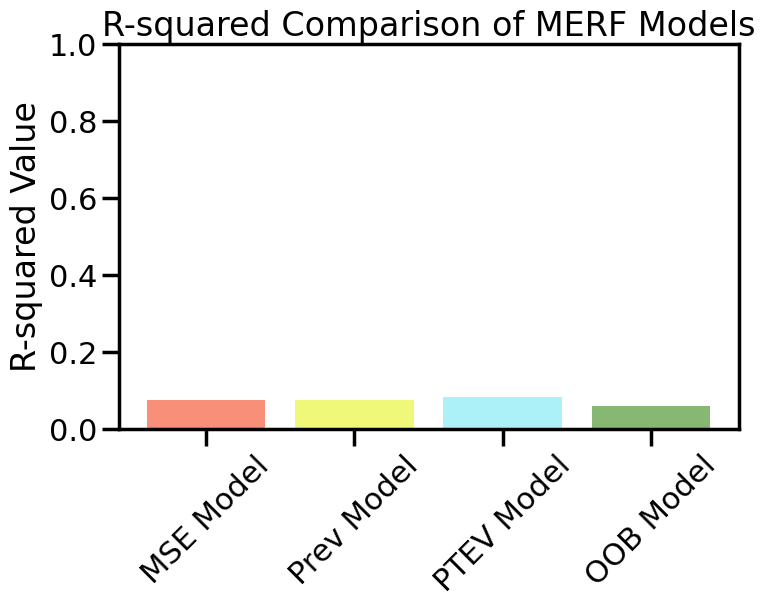

Best model: PTEV Model with R-squared: 0.0837
Top 15 feature importances for the best model:
                                            Feature  Importance
7                                           HOMA_IR    0.363663
8                                      Insulin_endo    0.076885
605                                      g__Dorea_A    0.018663
53                                    Isochorismate    0.017321
598                                g__Enterocloster    0.013526
358               TCA.cycle.VII..acetate.producers.    0.012373
202       superpathway.of.polyamine.biosynthesis.II    0.011931
524                                      g__UBA1417    0.011904
10                               Triglyceride_lipid    0.011286
370  aromatic.biogenic.amine.degradation..bacteria.    0.010242
1                                     cohort_number    0.008875
40                               o.Succinylbenzoate    0.008411
545                               g__Ruminococcus_D    0.008034
5          

In [10]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_omics_merf_bmi_long_feb6.png'
feature_imp_out = 'fi_all_omics_merf_bmi_long_feb6.png'

print("---------- Select predictors for training set ----------")
train_set = train_long
X = train_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)
Y = train_set['outcome_bmi_fnl'].to_numpy()
clusters_train = train_set['all_samples'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_long
X_new = test_set.drop(['outcome_bmi_fnl', 'all_samples'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['outcome_bmi_fnl'].to_numpy()  
clusters_new = pd.Series(test_set['all_samples'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  long_df, output_dir, r2_out, feature_imp_out)

r2_run6, fi_run6 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

print("---------- Run best MERF 🧮 ----------")
param_grid_list = [
    {'n_estimators': 100, 'max_depth': None, 
     'min_samples_split': 0.05, 'max_iter': 2}
]
# Call the run_merf function with the required parameters
# all_omic = run_merf(X, Y, Z, clusters_train,
#                      X_new, Y_new, Z_new, clusters_new, 
#                      param_grid_list, results_name="grs_tax_func_micom")
# # View the "only_meta" output
# print("Viewing the 'only_meta' output:")
# for result in all_omic:
#     print(f"Model Parameters: {result['params']}")
#     print(f"R-squared: {result['r2']:.4f}")
#     print("Feature Importances:")
#     for feature, importance in zip(X.columns, result['feature_importances']):
#         print(f"{feature}: {importance:.4f}")
#     print("\n")

# Now looking at Delta models 

In [11]:
print("test delta: ", list(test_delta.shape))
print("train delta: ", list(train_delta.shape))
print("test delta: ", list(test_delta.columns))
print("train delta: ", list(train_delta.columns))

test delta:  [62, 920]
train delta:  [234, 920]
test delta:  ['subject_id', 'randomized_group', 'age', 'sex', 'race', 'BMI', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HDL', 'LDL', 'HbA1C', 'insulin', 'leptin', 'peptide_yy', 'tgcyd', 'homo_ir', 'DENOVOPURINE2-PWY', 'DHGLUCONATE-PYR-CAT-PWY', 'DTDPRHAMSYN-PWY', 'ECASYN-PWY', 'ENTBACSYN-PWY', 'FAO-PWY', 'FASYN-ELONG-PWY', 'FASYN-INITIAL-PWY', 'FERMENTATION-PWY', 'FOLSYN-PWY', 'FUC-RHAMCAT-PWY', 'FUCCAT-PWY', 'GALACT-GLUCUROCAT-PWY', 'GALACTARDEG-PWY', 'GALACTUROCAT-PWY', 'GALLATE-DEGRADATION-I-PWY', 'GALLATE-DEGRADATION-II-PWY', 'GLCMANNANAUT-PWY', 'GLUCARDEG-PWY', 'GLUCARGALACTSUPER-PWY', 'GLUCONEO-PWY', 'GLUCOSE1PMETAB-PWY', 'GLUCUROCAT-PWY', 'GLUTORN-PWY', 'GLYCOCAT-PWY', 'GLYCOGENSYNTH-PWY', 'GLYCOL-GLYOXDEG-PWY', 'GLYCOLYSIS', 'GLYCOLYSIS-E-D', 'GLYCOLYSIS-TCA-GLYOX-BYPASS', 'GLYOXYLATE-BYPASS', 'GOLPDLCAT-PWY', 'HCAMHPDEG-PWY', 'HEME-BIOSYNTHESIS-II', 'HEMESYN2-PWY', 'HEXITOLDEGSUPER-PWY', 'HISDEG-PWY', 'HISTSYN-PWY', 'HOMOSER-MET

In [12]:
# Find the column numbers for "proton" and "Carbon.dioxide" in train_set
proton_column = train_delta.columns.get_loc("proton")
carbon_dioxide_column = train_delta.columns.get_loc("Carbon.dioxide")
proton_column_test = test_delta.columns.get_loc("proton")
carbon_dioxide_column_test = test_delta.columns.get_loc("Carbon.dioxide")
print("Column number for 'proton': ", proton_column)
print("Column number for 'Carbon.dioxide': ", carbon_dioxide_column)

# Columns to KEEP for only meta 
meta_keep = ['subject_id','BMI', 'randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd']

# Columns to KEEP for only meta + GRS + taxa
meta_grs_taxa = meta_keep + [col for col in train_delta.columns if col.startswith("g__")]
meta_grs_taxa_test = meta_keep + [col for col in test_delta.columns if col.startswith("g__")]

# Columns to KEEP for only meta + GRS + taxa + pathway/functional 
meta_grs_taxa_functional = meta_grs_taxa + [col for col in train_delta.columns if col not in train_delta.columns[proton_column:carbon_dioxide_column+1]]
meta_grs_taxa_functional_test = meta_grs_taxa_test + [col for col in test_delta.columns if col not in test_delta.columns[proton_column_test:carbon_dioxide_column_test+1]]

# Columns to DROP for only GRS + taxa + pathway/functional + micom (no meta)
all_but_meta = ['randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd', 'Weight', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range']

Column number for 'proton':  828
Column number for 'Carbon.dioxide':  918


## 2.1 Only Meta Delta 

In [13]:
# Check for missing columns in train_delta
missing_columns = [col for col in meta_keep if col not in train_delta.columns]

if missing_columns:
    print("Missing columns in train_delta:", missing_columns)
else:
    print("All columns in meta_keep are present in train_delta.")

All columns in meta_keep are present in train_delta.


---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits               5.00
Name: 31, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.05
max_iter               2.00
n_splits              10.00
Name: 2, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter               10.00
n_splits               10.00
Name: 41, dtype: float64
-

INFO     [merf.py:307] Training GLL is 331.5950797847328 at iteration 1.
INFO     [merf.py:307] Training GLL is 334.20338456567765 at iteration 2.
INFO     [merf.py:307] Training GLL is 332.1728760379998 at iteration 1.
INFO     [merf.py:307] Training GLL is 333.5063032747798 at iteration 2.
INFO     [merf.py:307] Training GLL is 146.94294770897628 at iteration 1.
INFO     [merf.py:307] Training GLL is 165.89019197531795 at iteration 2.
INFO     [merf.py:307] Training GLL is 150.03894181004242 at iteration 1.
INFO     [merf.py:307] Training GLL is 162.00662418747154 at iteration 2.
INFO     [merf.py:307] Training GLL is 155.6992724388806 at iteration 3.
INFO     [merf.py:307] Training GLL is 146.36943686467134 at iteration 4.
INFO     [merf.py:307] Training GLL is 139.74064661139252 at iteration 5.
INFO     [merf.py:307] Training GLL is 133.0461080366131 at iteration 6.
INFO     [merf.py:307] Training GLL is 122.61782188977473 at iteration 7.
INFO     [merf.py:307] Training GLL is 115.

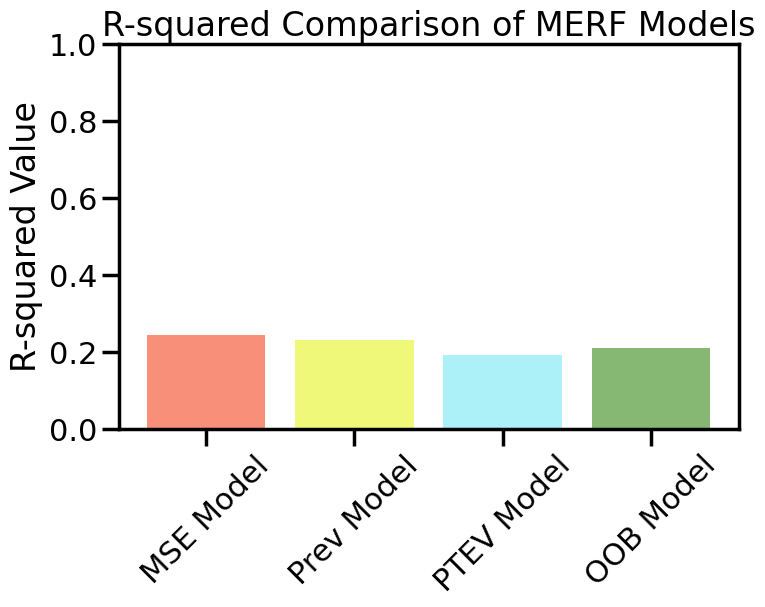

Best model: MSE Model with R-squared: 0.2429
Top 15 feature importances for the best model:
            Feature  Importance
5           homo_ir    0.513404
8             tgcyd    0.195301
6           insulin    0.128963
4               HDL    0.049808
2              race    0.043769
7               LDL    0.039896
3               age    0.024065
0  randomized_group    0.003345
1               sex    0.001449


In [14]:
train_l = train_delta[meta_keep]
test_l = test_delta[meta_keep]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_only_meta_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_only_meta_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run1, fi_delta_run1 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             long_df, output_dir, r2_out, feature_imp_out)

## 2.2 Ok now include meta and taxa deltas 

There is no change in bmi_prs so that is not included in the delta models 

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is 173.10357834900648 at iteration 1.
INFO     [merf.py:307] Training GLL is 192.2961824293365 at iteration 2.
INFO     [merf.py:307] Training GLL is 185.68398081594407 at iteration 3.
INFO     [merf.py:307] Training GLL is 182.49326861775558 at iteration 4.
INFO     [merf.py:307] Training GLL is 174.5896657117569 at iteration 5.
INFO     [merf.py:307] Training GLL is 166.7674414977439 at iteration 6.
INFO     [merf.py:307] Training GLL is 158.26098609482594 at iteration 7.
INFO     [merf.py:307] Training GLL is 153.2803440399346 at iteration 8.
INFO     [merf.py:307] Training GLL is 145.73029217498686 at iteration 9.
INFO     [merf.py:307] Training GLL is 144.96722608398832 at iteration 10.
INFO     [merf.py:307] Training GLL is 73.21600678220967 at iteration 1.
INFO     [merf.py:307] Training GLL is 80.57833583083212 at iteration 2.
INFO     [merf.py:307] Training GLL is 248.05892939016147 at iteration 1.
INFO     [merf.py:307] Training GLL is 266.

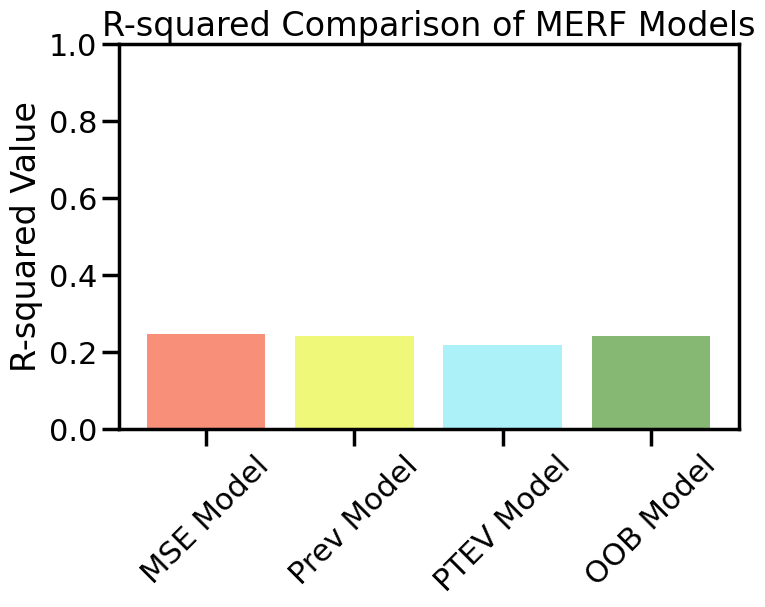

Best model: MSE Model with R-squared: 0.2458
Top 15 feature importances for the best model:
                     Feature  Importance
5                    homo_ir    0.311304
8                      tgcyd    0.100674
6                    insulin    0.077809
116      g__Blautia_A_141781    0.035693
134  g__Coprococcus_A_187866    0.028327
7                        LDL    0.026317
2                       race    0.021203
4                        HDL    0.019741
410    g__Escherichia_710834    0.015563
107         g__Acetatifactor    0.012117
210              g__UMGS1071    0.011340
432           g__Akkermansia    0.010984
260        g__Ruminococcus_D    0.010389
3                        age    0.010144
101          g__Anaerofustis    0.009565


In [15]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_taxa_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_meta_taxa_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'subject_id'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run2, fi_delta_run2 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             delta_df, output_dir, r2_out, feature_imp_out)

## 2.3 Delta variables Meta + Taxa + Functional

In [16]:
train_l = train_delta[meta_grs_taxa]
test_l = test_delta[meta_grs_taxa_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

In [33]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

print("Columns in train_l DataFrame:")
print(list(train_l.columns))  # Convert to list for better readability

Columns in train_l DataFrame:
['subject_id', 'BMI', 'randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd', 'g__Methanobrevibacter_A', 'g__Methanosphaera', 'g__UBA71', 'g__Actinomyces', 'g__Actinotignum', 'g__Pauljensenia', 'g__Peptidiphaga', 'g__Varibaculum', 'g__Winkia', 'g__Alloscardovia', 'g__Bifidobacterium_388775', 'g__Scardovia', 'g__Rothia', 'g__Specibacter', 'g__Corynebacterium', 'g__Lawsonella', 'g__Atopobium', 'g__Lancefieldella', 'g__Olegusella', 'g__Parolsenella', 'g__Thermophilibacter', 'g__UBA1367', 'g__Collinsella', 'g__Adlercreutzia_404199', 'g__Adlercreutzia_404218', 'g__Adlercreutzia_404257', 'g__CAG-1427', 'g__Cryptobacterium', 'g__Eggerthella', 'g__Ellagibacter', 'g__Gordonibacter', 'g__Paraeggerthella', 'g__Raoultibacter', 'g__Senegalimassilia', 'g__Slackia_A', 'g__QAMH01', 'g__Alloprevotella', 'g__Bacteroides_H', 'g__Paraprevotella', 'g__Phocaeicola_A_858004', 'g__Prevotella', 'g__Barnesiella', 'g__CABJAA01', 'g__Coprobacter', 'g__D

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is 172.43840460083567 at iteration 1.
INFO     [merf.py:307] Training GLL is 194.52013659380606 at iteration 2.
INFO     [merf.py:307] Training GLL is 188.03505096835138 at iteration 3.
INFO     [merf.py:307] Training GLL is 181.7255879640588 at iteration 4.
INFO     [merf.py:307] Training GLL is 177.12987746373074 at iteration 5.
INFO     [merf.py:307] Training GLL is 170.81956551106572 at iteration 6.
INFO     [merf.py:307] Training GLL is 164.7699451316737 at iteration 7.
INFO     [merf.py:307] Training GLL is 160.8111989707329 at iteration 8.
INFO     [merf.py:307] Training GLL is 155.66320162742082 at iteration 9.
INFO     [merf.py:307] Training GLL is 149.2396291436663 at iteration 10.
INFO     [merf.py:307] Training GLL is 65.54988789445677 at iteration 1.
INFO     [merf.py:307] Training GLL is 85.04923235918076 at iteration 2.
INFO     [merf.py:307] Training GLL is 240.65173298727353 at iteration 1.
INFO     [merf.py:307] Training GLL is 266.

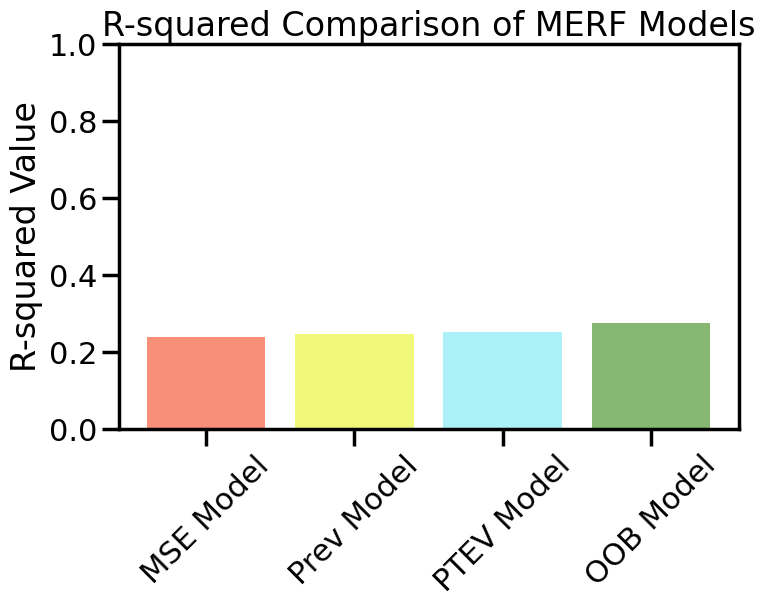

Best model: OOB Model with R-squared: 0.2746
Top 15 feature importances for the best model:
                     Feature  Importance
5                    homo_ir    0.242996
8                      tgcyd    0.089063
6                    insulin    0.067143
134  g__Coprococcus_A_187866    0.033716
712                 PWY-7254    0.028213
7                        LDL    0.027352
583                 PWY-5677    0.021182
4                        HDL    0.020348
2                       race    0.016676
116      g__Blautia_A_141781    0.015997
468      HEXITOLDEGSUPER-PWY    0.014497
3                        age    0.012175
101          g__Anaerofustis    0.009763
731                 PWY-7456    0.007070
523             PPGPPMET-PWY    0.006360


In [34]:
train_l = train_delta[meta_grs_taxa_functional]
test_l = test_delta[meta_grs_taxa_functional_test]

# Check for duplicate column names in train_l and test_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()

# Count of duplicate columns
num_duplicates_train = len(duplicates_train)
num_duplicates_test = len(duplicates_test)

# Remove duplicate columns from train_l
train_l = train_l.loc[:, ~train_l.columns.duplicated()]
test_l = test_l.loc[:, ~test_l.columns.duplicated()]

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_meta_taxa_functional_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_meta_taxa_functional_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI', 'Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run3, fi_delta_run3 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             delta_df, output_dir, r2_out, feature_imp_out)

## 2.4 all delta omics except meta 

In [18]:


print("test longitudinal: ", list(test_l.columns))
print("train longitudinal: ", list(train_l.columns))

# Print duplicated column names in test_l
duplicates_test = test_l.columns[test_l.columns.duplicated()].unique()
print("Duplicated columns in test_l: ", duplicates_test)

# Print duplicated column names in train_l
duplicates_train = train_l.columns[train_l.columns.duplicated()].unique()
print("Duplicated columns in train_l: ", duplicates_train)


test longitudinal:  ['subject_id', 'BMI', 'randomized_group', 'sex', 'race', 'age', 'HDL', 'homo_ir', 'insulin', 'LDL', 'tgcyd', 'g__Methanobrevibacter_A', 'g__Methanosphaera', 'g__UBA71', 'g__Actinomyces', 'g__Actinotignum', 'g__Pauljensenia', 'g__Peptidiphaga', 'g__Varibaculum', 'g__Winkia', 'g__Alloscardovia', 'g__Bifidobacterium_388775', 'g__Scardovia', 'g__Rothia', 'g__Specibacter', 'g__Corynebacterium', 'g__Lawsonella', 'g__Atopobium', 'g__Lancefieldella', 'g__Olegusella', 'g__Parolsenella', 'g__Thermophilibacter', 'g__UBA1367', 'g__Collinsella', 'g__Adlercreutzia_404199', 'g__Adlercreutzia_404218', 'g__Adlercreutzia_404257', 'g__CAG-1427', 'g__Cryptobacterium', 'g__Eggerthella', 'g__Ellagibacter', 'g__Gordonibacter', 'g__Paraeggerthella', 'g__Raoultibacter', 'g__Senegalimassilia', 'g__Slackia_A', 'g__QAMH01', 'g__Alloprevotella', 'g__Bacteroides_H', 'g__Paraprevotella', 'g__Phocaeicola_A_858004', 'g__Prevotella', 'g__Barnesiella', 'g__CABJAA01', 'g__Coprobacter', 'g__Dysgonomona

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is 271.9598104130905 at iteration 1.
INFO     [merf.py:307] Training GLL is 278.44460906421057 at iteration 2.
INFO     [merf.py:307] Training GLL is 268.507456178791 at iteration 3.
INFO     [merf.py:307] Training GLL is 259.2234624457738 at iteration 4.
INFO     [merf.py:307] Training GLL is 254.14456414917794 at iteration 5.
INFO     [merf.py:307] Training GLL is 250.2157186411186 at iteration 6.
INFO     [merf.py:307] Training GLL is 246.73203362799163 at iteration 7.
INFO     [merf.py:307] Training GLL is 240.87003760863257 at iteration 8.
INFO     [merf.py:307] Training GLL is 233.50789598564822 at iteration 9.
INFO     [merf.py:307] Training GLL is 227.8002925308759 at iteration 10.
INFO     [merf.py:307] Training GLL is 213.35689363476368 at iteration 1.
INFO     [merf.py:307] Training GLL is 214.83727452252052 at iteration 2.
INFO     [merf.py:307] Training GLL is 317.0570574151872 at iteration 1.
INFO     [merf.py:307] Training GLL is 316.1

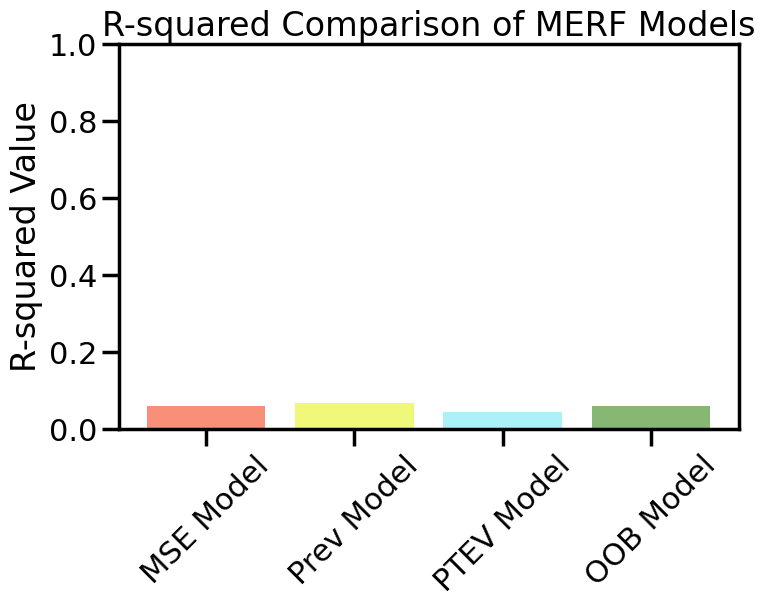

Best model: Prev Model with R-squared: 0.0685
Top 15 feature importances for the best model:
                     Feature  Importance
495  g__Coprococcus_A_187866    0.061284
35       HEXITOLDEGSUPER-PWY    0.059825
477      g__Blautia_A_141781    0.035333
150                 PWY-5677    0.032142
279                 PWY-7254    0.030533
493                  g__COE1    0.022473
593           g__Limivicinus    0.017536
68                  P164-PWY    0.015880
463   g__Anaerotignum_189125    0.014820
714           g__Longicatena    0.014542
252                 PWY-7013    0.012704
850                  Choline    0.011466
573              g__UMGS1071    0.011105
51       NAD-BIOSYNTHESIS-II    0.010426
88             POLYAMSYN-PWY    0.010284


In [35]:
train_l = train_delta.drop(all_but_meta, axis = 1)
test_l = test_delta.drop(all_but_meta, axis = 1)

output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_taxa_functional_micom_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_taxa_functional_micom_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_l
X = train_set.drop(['BMI','subject_id', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_l
X_new = test_set.drop(['BMI','subject_id', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run4, fi_delta_run4 = run_merf_analysis2(X, Y, Z, clusters_train,
                             X_new, Y_new, Z_new, clusters_new, 
                             delta_df, output_dir, r2_out, feature_imp_out)

## 2.5 all delta varibles 

---------- Select predictors for training set ----------
---------- Select predictors for test set ----------
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators         500.0
max_depth              NaN
min_samples_split      0.1
max_iter              10.0
n_splits              10.0
Name: 29, dtype: float64
First 5 columns for the lowest mean_prev_score:
n_estimators         1000.00
max_depth                NaN
min_samples_split       0.05
max_iter                2.00
n_splits                3.00
Name: 36, dtype: float64
First 5 columns for the lowest mean_ptev_score:
n_estimators         100.00
max_depth               NaN
min_samples_split      0.15
max_iter               2.00
n_splits              10.00
Name: 14, dtype: float64

First 5 columns for the highest oob_score:
n_estimators         500.00
max_depth               NaN
min_samples_split      0.05
max_iter              10.00
n_splits               3.00
Name: 21, dtype: float64
-----

INFO     [merf.py:307] Training GLL is 176.20097149140855 at iteration 1.
INFO     [merf.py:307] Training GLL is 197.50001441134927 at iteration 2.
INFO     [merf.py:307] Training GLL is 194.76872288387946 at iteration 3.
INFO     [merf.py:307] Training GLL is 185.33243590344375 at iteration 4.
INFO     [merf.py:307] Training GLL is 183.4160766223513 at iteration 5.
INFO     [merf.py:307] Training GLL is 171.33354957463877 at iteration 6.
INFO     [merf.py:307] Training GLL is 163.87316217308336 at iteration 7.
INFO     [merf.py:307] Training GLL is 158.25791912152036 at iteration 8.
INFO     [merf.py:307] Training GLL is 155.27599195556476 at iteration 9.
INFO     [merf.py:307] Training GLL is 147.69440237855616 at iteration 10.
INFO     [merf.py:307] Training GLL is 75.45903687925745 at iteration 1.
INFO     [merf.py:307] Training GLL is 87.38566271941205 at iteration 2.
INFO     [merf.py:307] Training GLL is 254.10200896086639 at iteration 1.
INFO     [merf.py:307] Training GLL is 2

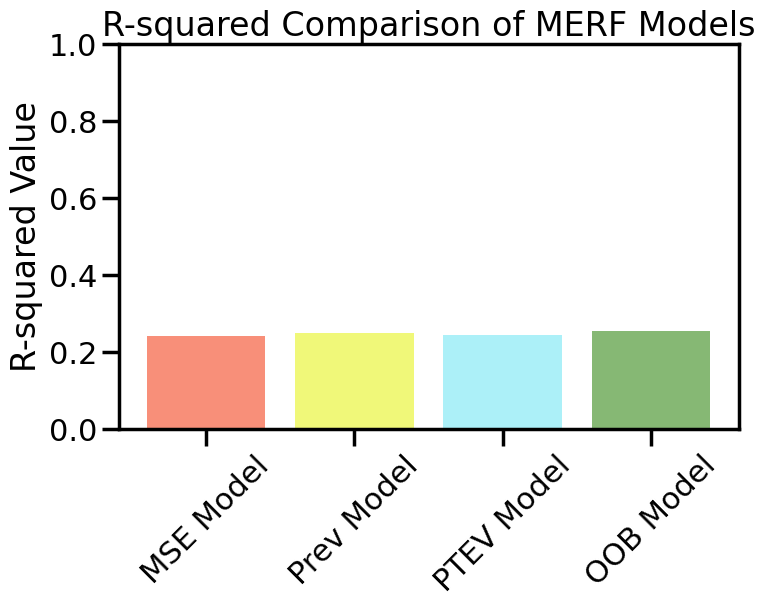

Best model: OOB Model with R-squared: 0.2548
Top 15 feature importances for the best model:
                     Feature  Importance
8                    homo_ir    0.241161
7                      tgcyd    0.080046
6                    insulin    0.071544
288                 PWY-7254    0.027103
5                        LDL    0.026416
504  g__Coprococcus_A_187866    0.023563
159                 PWY-5677    0.022592
3                       race    0.018574
4                        HDL    0.017412
1                        age    0.013011
486      g__Blautia_A_141781    0.012681
44       HEXITOLDEGSUPER-PWY    0.010212
307                 PWY-7456    0.008339
99              PPGPPMET-PWY    0.006415
824        X2.methylbutyrate    0.005729


In [36]:
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/long_combined"
r2_out = 'r2_all_omic_merf_bmi_delta_feb7.png'
feature_imp_out = 'fi_all_omic_merf_bmi_delta_feb7.png'

print("---------- Select predictors for training set ----------")
train_set = train_delta
X = train_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)
Y = train_set['BMI'].to_numpy()
clusters_train = train_set['subject_id'].to_numpy() 
Z = np.ones((train_set.shape[0], 1)) 

print("---------- Select predictors for test set ----------")
test_set = test_delta
X_new = test_set.drop(['BMI','Weight','subject_id', 'CRP', 'cholesterol', 'ghrelin', 'HbA1C', 'leptin', 'peptide_yy', 'range'], axis=1)[X.columns].astype(X.dtypes)
Y_new = test_set['BMI'].to_numpy()  
clusters_new = pd.Series(test_set['subject_id'])  
Z_new = np.ones((len(X_new), 1))

print("---------- Run MERF models ----------")
#run_merf_analysis(X, Y, Z, clusters_train, 
#                  X_new, Y_new, Z_new, clusters_new, 
#                  meta_df, output_dir, r2_out, feature_imp_out)

#r2_delta_run5 = run_merf_analysis2(X, Y, Z, clusters_train,
#                             X_new, Y_new, Z_new, clusters_new, 
#                             delta_df, output_dir, r2_out, feature_imp_out)

r2_delta_run5, fi_delta_run5 = run_merf_analysis2(X, Y, Z, clusters_train, 
                                              X_new, Y_new, Z_new, clusters_new, 
                                              delta_df, output_dir, r2_out, feature_imp_out)

# Now you can use `top_features` for plotting or further analysis

# Comparing all models above 

In [21]:
def compare_r2_values1(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 
    print(r2_comparison_df.head(10).columns[:10])
    print(r2_comparison_df.head(10))

    # Sort the DataFrame by R-squared values in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=model_names, ascending=False)

    # Set up the bar positions
    num_runs = len(r2_comparison_df.columns)
    bar_width = 0.15  # Width of each bar
    x = np.arange(len(r2_comparison_df))  # The label locations

    # Create a color map for the models
    colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

    # Create bars for each model in each run
    for i in range(num_runs):
        plt.bar(x + i * bar_width, r2_comparison_df.iloc[:, i],  # Use plt.bar for vertical bars
                 width=bar_width, label=model_names[i], color=colors[i])  # Use model names for labels

    # Add labels, title, and custom x-axis tick labels
    plt.ylabel('R-squared Value')  # Change to y-label
    plt.title('R-squared Comparison of Different Runs')
    plt.ylim(0, 0.55)  # Assuming R-squared values are between 0 and 1
    plt.xticks(x + bar_width * (num_runs - 1) / 2, r2_comparison_df.index)  # Center the x-ticks
    plt.legend(title='Models', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

Index(['Only Meta', 'Meta GRS', 'Meta GRS Tax', 'Meta GRS Tax Func',
       'All But Meta', 'All Omic'],
      dtype='object')
            Only Meta  Meta GRS  Meta GRS Tax  Meta GRS Tax Func  \
MSE Model    0.088542  0.103923      0.042630           0.069735   
Prev Model   0.080929  0.114427      0.057106           0.075052   
PTEV Model   0.156786  0.125682      0.050065           0.117564   
OOB Model    0.044536  0.064894      0.036602           0.058838   

            All But Meta  All Omic  
MSE Model      -0.103285  0.075575  
Prev Model     -0.092420  0.075909  
PTEV Model     -0.134389  0.083693  
OOB Model       0.010173  0.060920  


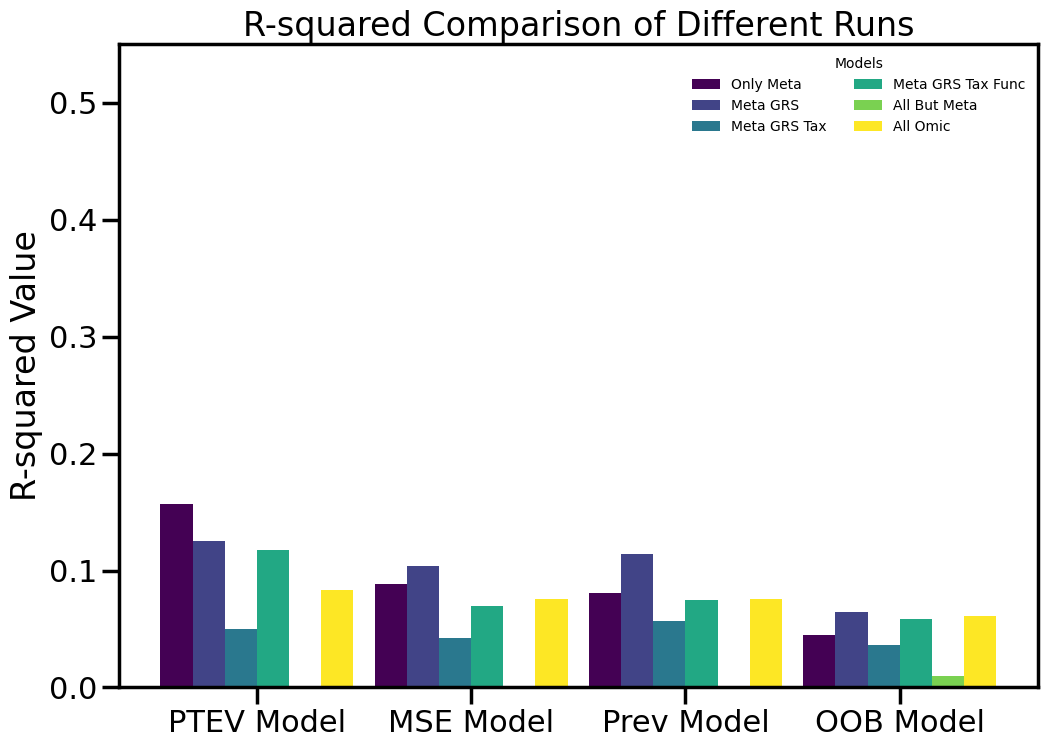

In [22]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values1(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

Index(['Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta',
       'All But Meta Delta', 'All Omic Delta'],
      dtype='object')
            Only Meta Delta  Meta Tax Delta  Meta Tax Func Delta  \
MSE Model          0.242936        0.245798             0.440102   
Prev Model         0.230884        0.241901             0.438150   
PTEV Model         0.192674        0.217958             0.449788   
OOB Model          0.210537        0.240715             0.395054   

            All But Meta Delta  All Omic Delta  
MSE Model             0.260258        0.438441  
Prev Model            0.257909        0.440541  
PTEV Model            0.261285        0.420410  
OOB Model             0.268852        0.419946  


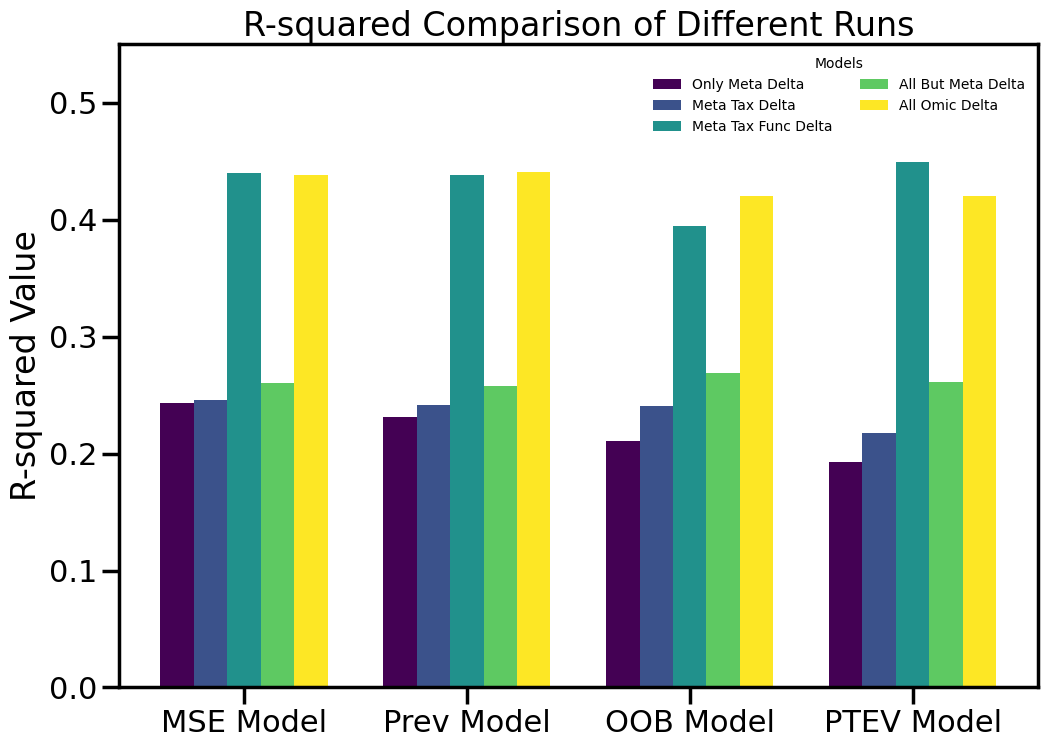

In [23]:
model_names_delta = ['Only Meta Delta',  
               'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']
compare_r2_values1(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values2(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(0.0, 0.35)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=9, 
               title_fontsize=8, ncol = 4, frameon=False)
    plt.tight_layout()
    plt.show()

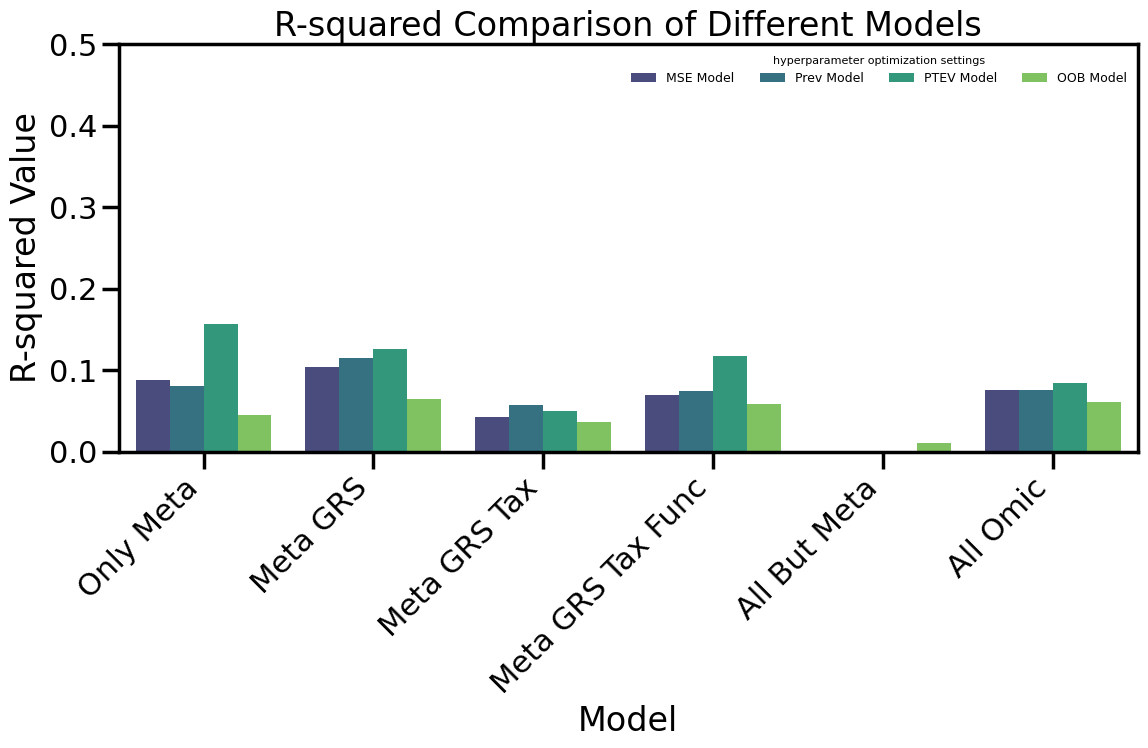

In [25]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values2(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

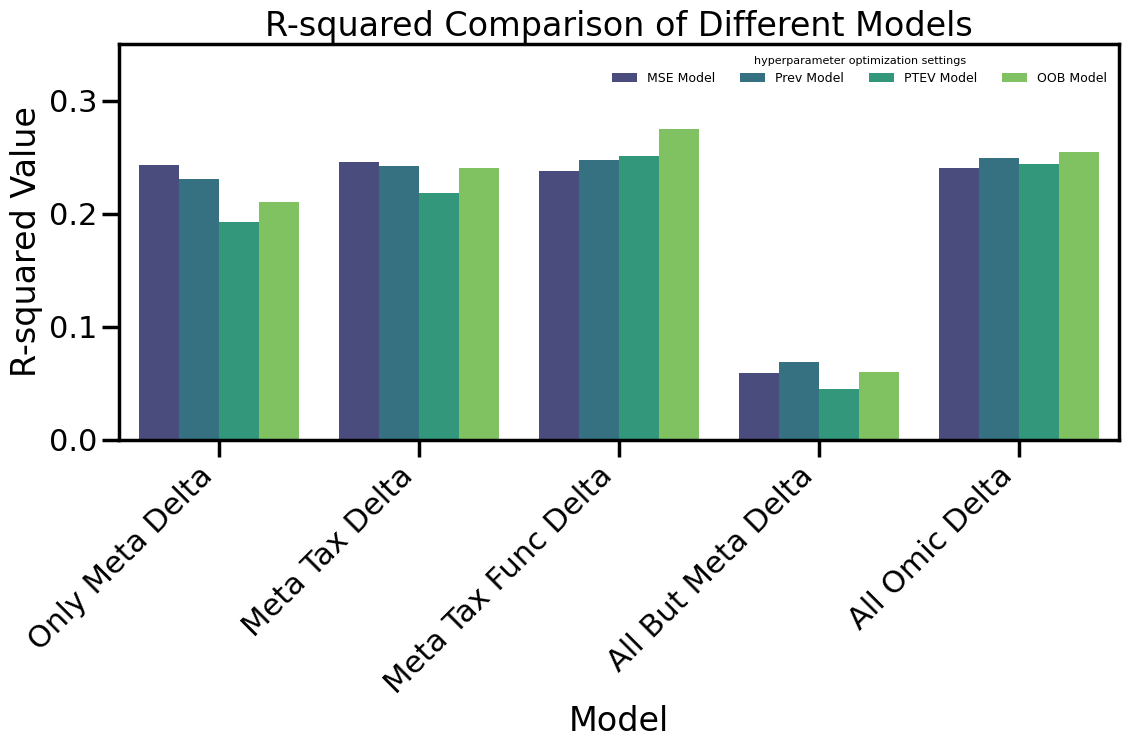

In [39]:
compare_r2_values2(model_names_delta, r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

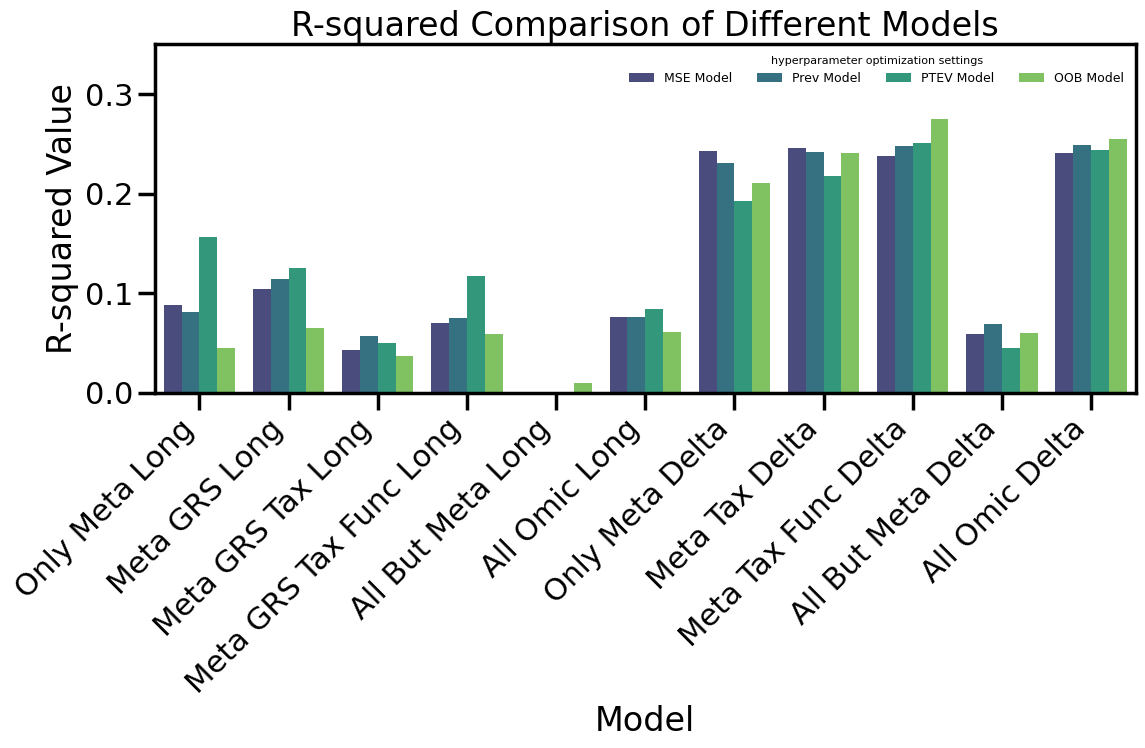

In [40]:
model_names_both = ['Only Meta Long', 'Meta GRS Long', 
               'Meta GRS Tax Long', 'Meta GRS Tax Func Long', 
               'All But Meta Long', 'All Omic Long', 
               'Only Meta Delta', 'Meta Tax Delta', 'Meta Tax Func Delta', 
               'All But Meta Delta', 'All Omic Delta']

compare_r2_values2(model_names_both, 
                   r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6,
                   r2_delta_run1, r2_delta_run2, 
                   r2_delta_run3, r2_delta_run4, r2_delta_run5)

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_r2_values3(model_names, *r2_dicts):
    # Create a DataFrame to hold the R-squared values
    r2_comparison_df = pd.DataFrame(r2_dicts).T
    r2_comparison_df.columns = model_names 

    # Reset index to use row names as a column
    r2_comparison_df.reset_index(inplace=True)
    r2_comparison_df = r2_comparison_df.melt(id_vars='index', var_name='Model', value_name='R-squared')

    # Rename the 'index' column to 'Metric' for clarity
    r2_comparison_df.rename(columns={'index': 'Metric'}, inplace=True)

    # Sort the DataFrame by 'Model' and then by 'R-squared' in descending order
    r2_comparison_df = r2_comparison_df.sort_values(by=['Metric', 'R-squared'], ascending=[True, False])

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=r2_comparison_df, x='Model', y='R-squared', hue='Metric', palette='viridis')

    # Add labels and title
    plt.ylabel('R-squared Value')
    plt.title('R-squared Comparison of Different Models')
    plt.ylim(-0.2, 0.2)  # Adjust y-limits based on your data range
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='hyperparameter optimization settings', loc='upper right', fontsize=10, 
               title_fontsize=10, ncol = 2, frameon=False)
    plt.tight_layout()
    plt.show()

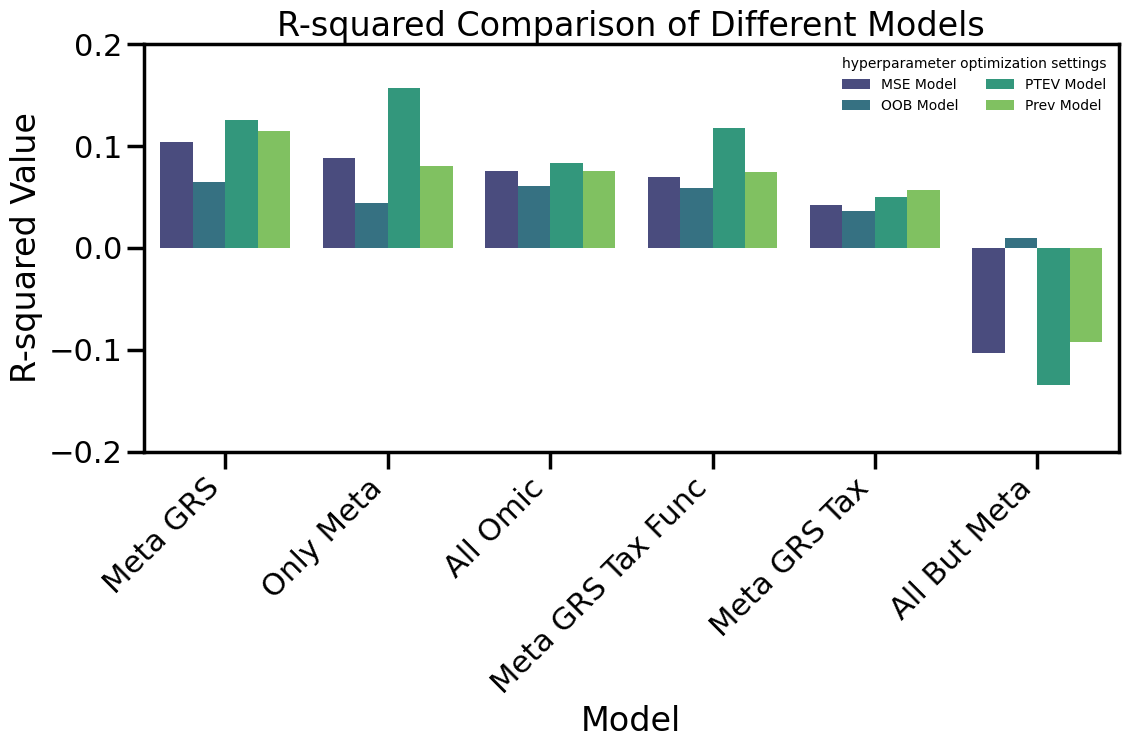

In [41]:
model_names = ['Only Meta', 'Meta GRS', 
               'Meta GRS Tax', 'Meta GRS Tax Func', 
               'All But Meta', 'All Omic']
compare_r2_values3(model_names, r2_run1, r2_run2, r2_run3, r2_run4, r2_run5, r2_run6)

In [42]:
feature_importance_dfs = [fi_run1, fi_run2, fi_run3, fi_run3, fi_run4, fi_run5, fi_run6,
                          fi_delta_run1, fi_delta_run2, fi_delta_run3, fi_delta_run4, fi_delta_run5]
plot_top_feature_importances_comparative(feature_importance_dfs)

Results List: [                   Feature  Importance
7                  HOMA_IR    0.424210
8             Insulin_endo    0.179520
10      Triglyceride_lipid    0.111312
5                  Glucose    0.073516
1            cohort_number    0.064936
6   HDL_Total_Direct_lipid    0.058024
4                      age    0.040994
9           LDL_Calculated    0.033517
3                     race    0.006281
0         randomized_group    0.003929
2                      sex    0.003760,                    Feature  Importance
7                  HOMA_IR    0.388718
8             Insulin_endo    0.172322
11                 bmi_prs    0.124658
10      Triglyceride_lipid    0.093725
5                  Glucose    0.057330
1            cohort_number    0.056522
6   HDL_Total_Direct_lipid    0.036960
9           LDL_Calculated    0.031045
4                      age    0.028909
3                     race    0.004937
2                      sex    0.002776
0         randomized_group    0.002096,         

TypeError: no numeric data to plot